In [ ]:
from os import makedirs
from os import listdir as lsdir
from os.path import join as pjoin
from os.path import exists as exist
from pathlib import Path
import glob
import sys
import pandas as pd
import shutil

import obspy
from obspy.clients.fdsn import Client
from obspy import read,read_inventory,read_events
from obspy.core import Stream,UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.trigger import classic_sta_lta,plot_trigger,recursive_sta_lta,trigger_onset
from obspy.taup import TauPyModel
from obspy.signal.trigger import classic_sta_lta,plot_trigger,recursive_sta_lta,trigger_onset
from obspy.imaging.spectrogram import spectrogram
from obspy.signal.polarization import polarization_analysis
from obspy.signal.rotate import rotate2zne
from obspy.core import event

import instaseis

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator as Mlc

import seaborn as sn
import matplotlib.dates as mpldates
import matplotlib as mpl
from matplotlib.patches import Rectangle

from IPython.display import clear_output

In [2]:
cat = read_events('/scratch/tolugboj_lab/Prj13_WAfr_seismicity/MT_SSMTI/Final_Work_Flow/quakes_xml/WafrQuakes90_21.xml')
#print(cat)
Data =  pd.read_csv('Output/Input_SSMTI/MTInputCatalog/WAMCA_input.csv')  

Data.sort_values(by=['country','origin'],inplace = True, ascending=[False,True])

Data=Data.reindex([6,10,3,4,8,7,11,9,5,2,1,0])
eq_Time_order = [9,13,4,6,11,10,14,12,8,3,2,1]
Data.reset_index(drop=True, inplace=True)
Data.insert(2, "indices",eq_Time_order, True)
Data.to_csv('Output/Others/WAMCA_input2.csv',index=False)
Data

,country,origin,indices,WAcat_index,lon,lat,depth,mag,magtype,station,...,Pick_S,S_corr,S_SNR,BBColors,Arrival_PS,All_phases,epi_distance_deg,azimuths,back_azimuths,folders
0,BENIN - TOGO REGION,2009-09-11T03:10:19.080000Z,9,186,2.17,6.68,10.0,4.4,mb,AF.SHAI,...,Yes,0.0,4.900000,orange,"[37.710683985612775, 66.745166220325387]","[37.710683985612775, 40.111130976544118, 41.61...",2.282419,248.608820,68.376531,BENI20090911T031019
1,GHANA,1997-03-06T15:16:32.740000Z,13,271,-0.23,5.59,10.0,4.4,mb,GT.DBIC,...,Yes,1.0,4.359172,orange,"[71.387872150307103, 127.29985235760142]","[71.387872150307103, 73.78989054300267, 75.295...",4.731878,282.887883,102.394789,GHAN19970306T151632
2,GHANA,2020-06-24T22:53:51.827000Z,4,5,-0.34,5.60,10.0,4.0,mb,IM.TOC4,...,Yes,-6.2,4.800000,orange,"[113.3378932038195, 202.66070600537864]","[113.3378932038195, 115.74381654569207, 117.24...",7.786328,14.796339,195.127773,GHAN20200624T225351
3,MAURITANIA,2013-01-08T15:33:10.180000Z,6,98,-12.21,22.71,10.0,4.2,mb,IM.TOC2,...,Yes,6.6,5.000000,black,"[229.18389118258227, 411.30183851554267]","[229.18389118258227, 231.75212490148542, 233.2...",16.317793,123.375488,307.688930,MAUR20130108T153310
4,MALI,2007-09-15T20:51:53.280000Z,11,225,-3.74,16.37,5.0,3.7,mb,G.TAM,...,Yes,-6.5,3.606884,saddlebrown,"[154.80871533904184, 276.9512297182867]","[154.80871533904184, 156.01510686773489, 156.7...",10.767829,52.975714,236.082358,MALI20070915T205153
5,NIGER,2008-04-29T15:05:32.780000Z,10,220,3.85,13.85,5.5,3.6,mb,IM.TOC4,...,Yes,2.6,5.800000,red,"[37.381822567115265, 66.071174514430453]","[37.381822567115265, 38.702552825018458, 39.53...",2.219252,251.930849,71.426541,NIGE20080429T150532
6,LIBERIA REGION,1995-11-25T00:04:41.700000Z,14,279,-10.90,6.80,10.0,4.5,mb,GT.DBIC,...,Yes,2.1,5.000000,purple,"[89.065610850310634, 159.0690559470103]","[89.065610850310634, 91.469011431998112, 92.97...",6.018450,91.257660,271.964573,LIBE19951125T000441
7,GUINEA REGION,2004-07-02T20:38:07.810000Z,12,252,-13.24,9.93,10.0,3.8,mb,GT.DBIC,...,Yes,6.0,4.900000,purple,"[129.1925498616242, 231.11197266764401]","[129.1925498616242, 131.60050696008781, 133.10...",8.942172,110.928043,292.137482,GUIN20040702T203807
8,GUINEA REGION,2012-08-23T22:03:51.150000Z,8,108,-13.08,11.75,10.0,4.2,mb,GT.DBIC,...,Yes,-6.1,4.800000,purple,"[138.24768478393156, 247.35194769979722]","[138.24768478393156, 140.65694622467237, 142.1...",9.602760,121.370618,302.686957,GUIN20120823T220351
9,GUINEA REGION,2020-10-31T07:20:38.829000Z,3,4,-8.55,9.41,10.0,4.5,mb,GT.DBIC,...,Yes,-6.7,3.698324,purple,"[69.484371175101046, 123.8781611249298]","[69.484371175101046, 71.886258368738311, 73.39...",4.593383,126.813435,307.328587,GUIN20201031T072038


0
2009-09-11T03:10:19.080000Z
1
1997-03-06T15:16:32.740000Z
2
2020-06-24T22:53:51.827000Z
3
2013-01-08T15:33:10.180000Z
4
2007-09-15T20:51:53.280000Z
5
2008-04-29T15:05:32.780000Z
6
1995-11-25T00:04:41.700000Z
7
2004-07-02T20:38:07.810000Z
8
2012-08-23T22:03:51.150000Z
9
2020-10-31T07:20:38.829000Z
10
2021-02-03T09:55:06.388000Z
11
2021-05-04T07:02:48.768000Z


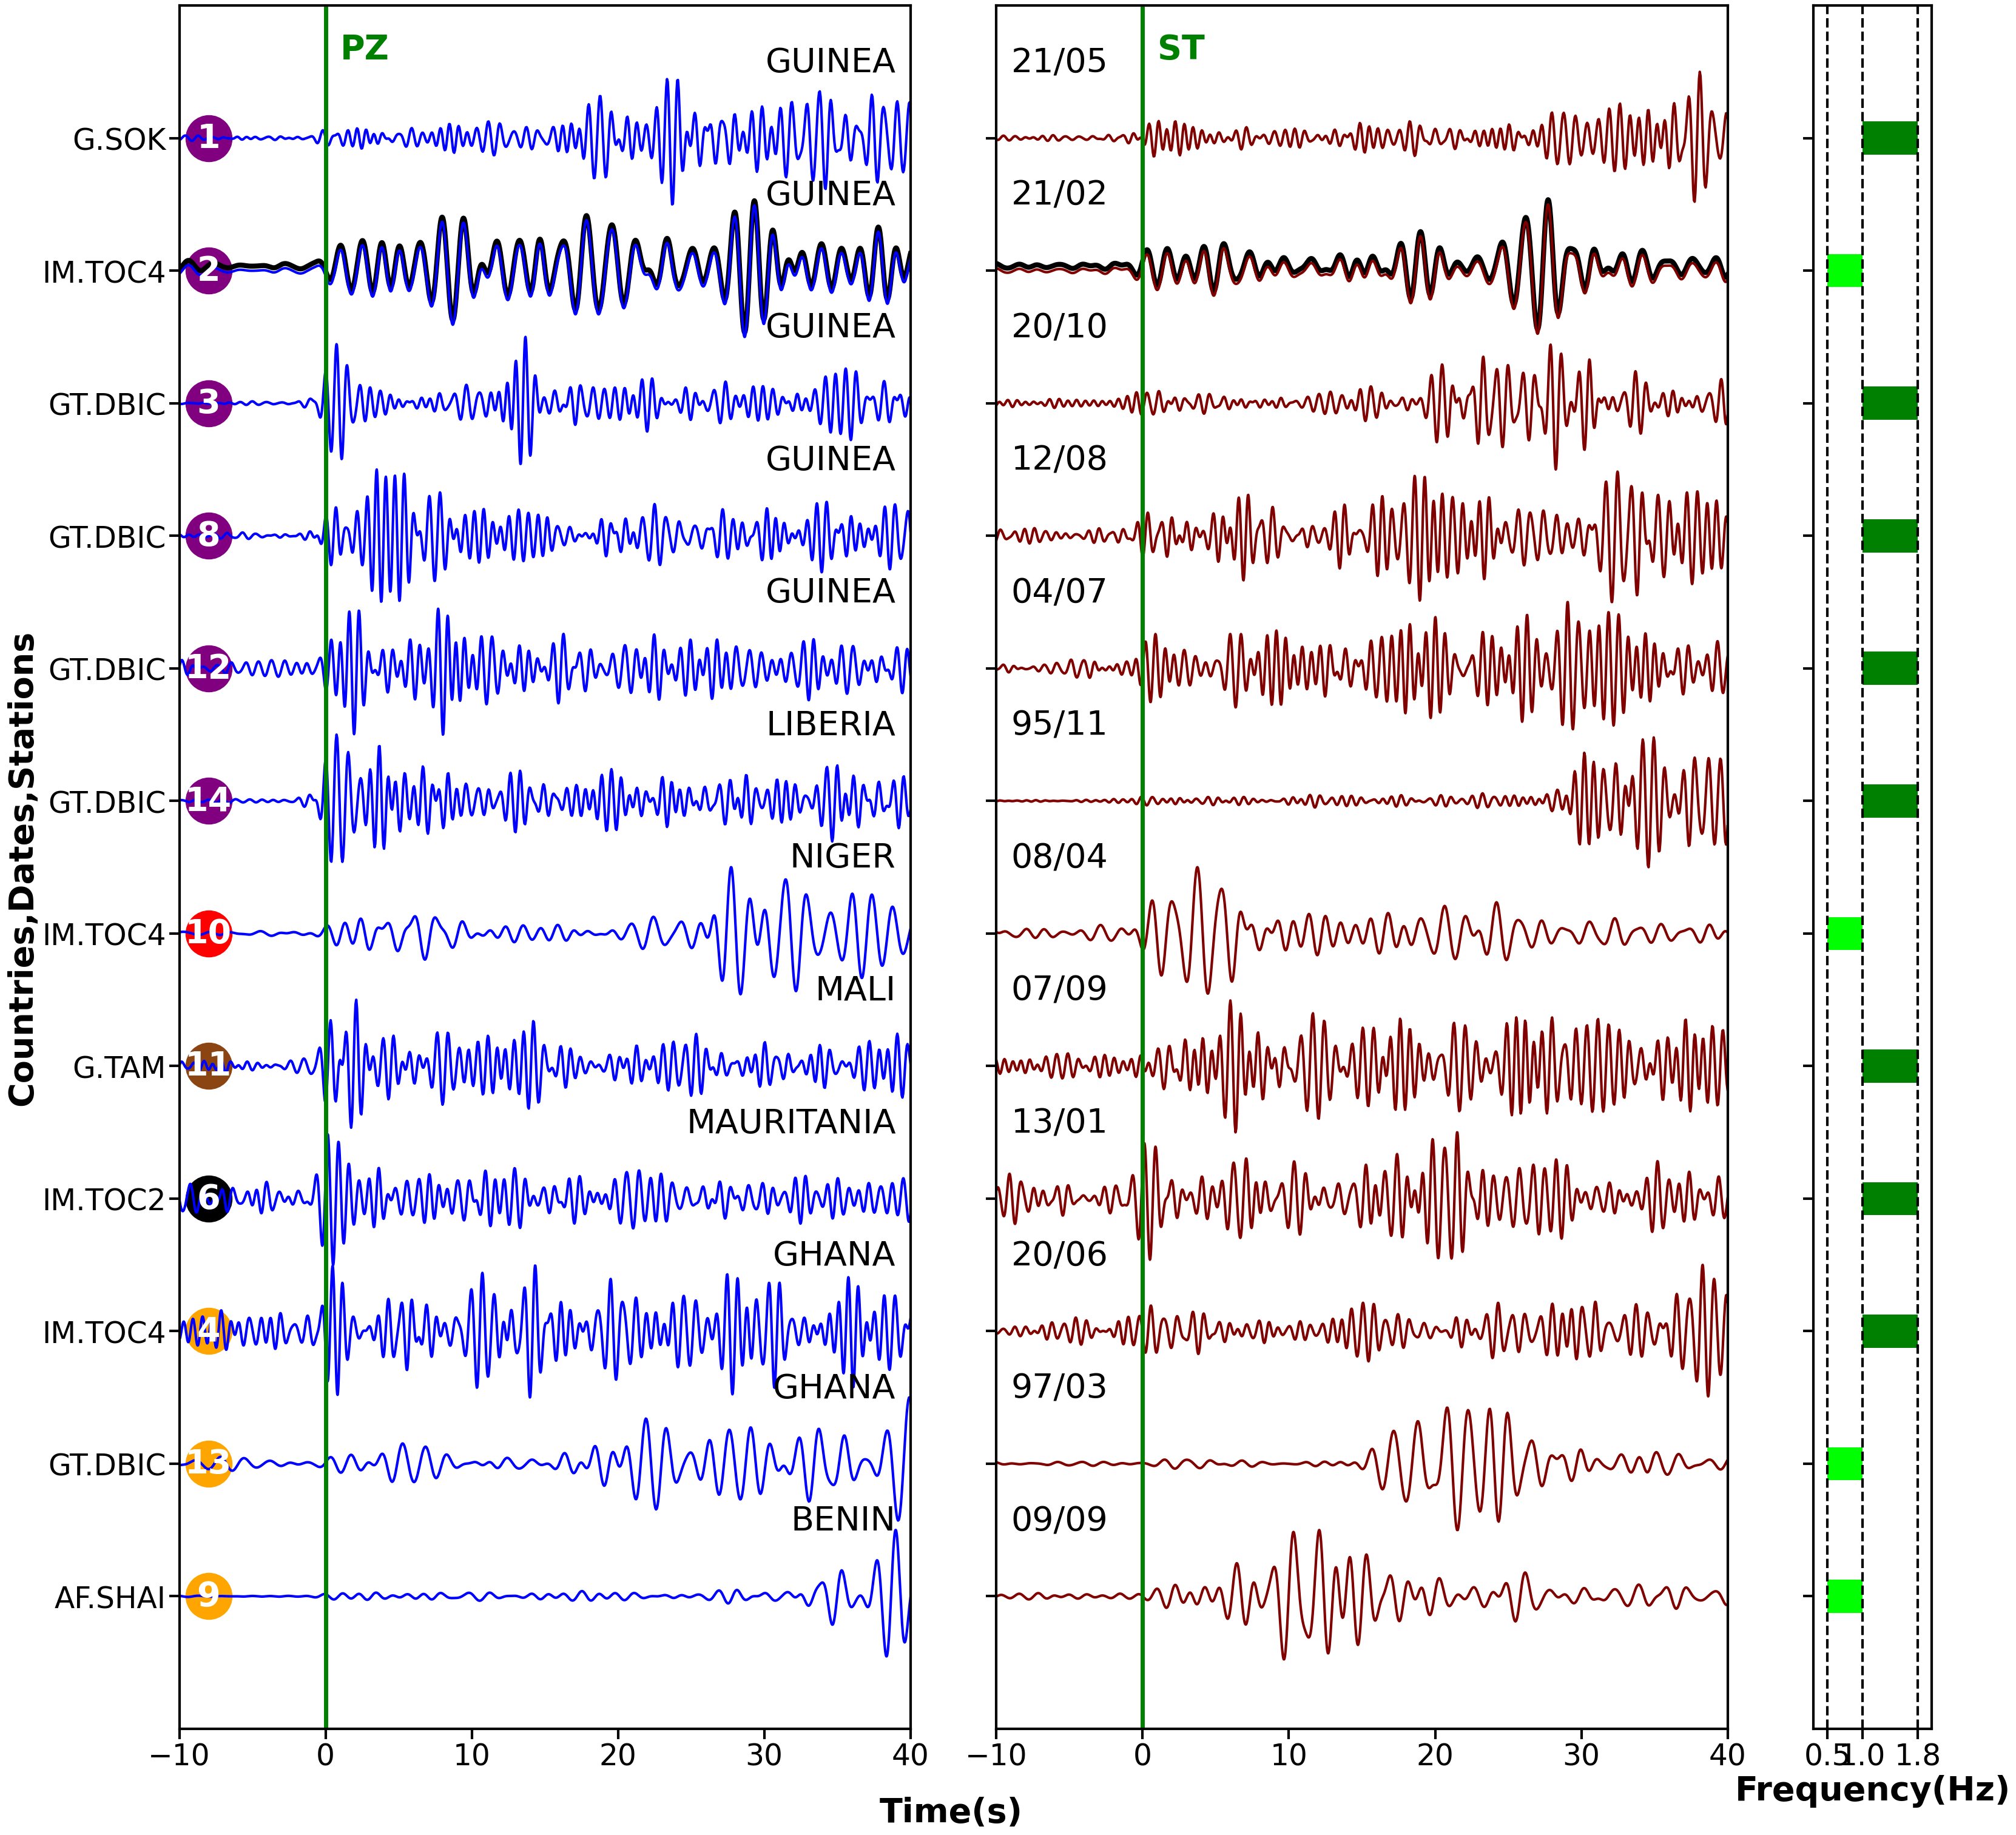

In [14]:
t_pre_test = [10, 10]
t_post_test = [40, 40]
indices=[]
yticklabels = []
label_countries=[]
label_times=[]
distances = []
magnitudes = []
freq_mins = Data['Freqmin'].values
freq_maxs = Data['Freqmax'].values
ind = 2

plt.style.use('default')
plt.rcParams["figure.figsize"] = (33,30)

ax1 = plt.subplot2grid((1, 18),(0, 0), colspan=8,rowspan=1)
ax2 = plt.subplot2grid((1, 18),(0,8), colspan=8,rowspan=1)
ax3 = plt.subplot2grid((1, 18),(0,16), colspan=2,rowspan=1)

                       
for eq,row in Data.iloc[0:].iterrows():
    print(eq)
    indices.append(ind)
    ev_index = row["WAcat_index"]
    event = cat[ev_index]
    print(event.origins[0].time)
    
    #event info
    orig_time = event.origins[0].time
    location = row['country']
    mag = row['mag'] #+" "+ row['magtype']
    
    folder = row['folders']
    sta_selected = row['station']
    label_time = str(orig_time)[2:4]+"/"+str(orig_time)[5:7]
    label_country = location
    yticklabel = sta_selected
    label_countries.append(label_country)
    label_times.append(label_time)
    yticklabels.append(yticklabel)
    
    baz = row['back_azimuths']
    dist = row['epi_distance_deg']
    distances.append(dist)
    


    P_corr=row['P_corr']
    S_corr=row['S_corr']
    
    
    
    P_S_arr=row['Arrival_PS'].strip("[]")
    P_S_arr=P_S_arr.split(",")
    
    freqmin= row['Freqmin']
    freqmax = row['Freqmax']
  
    
    corners = 3
   
    epicentral_distance_degree=row['epi_distance_deg']
    az=row['azimuths']
    baz=row['back_azimuths']


    path_to_waveform = "Output/Input_SSMTI/InputWaveforms/%s/%s*.mseed"%(folder,sta_selected)
    st= obspy.read(path_to_waveform)
    
    for tr in st:
        tr.stats.distance = dist
        tr.stats.back_azimuth = baz
    st.rotate(method="NE->RT")
    

    #P and S time
    ptt = float(P_S_arr[0])
    stt = float(P_S_arr[1])
    

    # Apply filter 
    st_filt = st.copy()
    st_filt =st_filt.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)

    #
    st_filtS = st_filt.copy()


    #P
    BHZwavP = st_filt.select(channel="BHZ")
    BHZwavP= BHZwavP.slice(starttime=orig_time + ptt + P_corr - t_pre_test[0],
                           endtime= orig_time + ptt + P_corr  + t_post_test[0],
                           )

    #S
    BHTwavS = st_filtS.select(channel="BHT")
    BHTwavS = BHTwavS.slice(starttime=orig_time + stt + S_corr - t_pre_test[1],
                           endtime= orig_time + stt + S_corr+ t_post_test[1],
                           )

    trPZ = BHZwavP.traces[0].data
    trPZ /= max(abs(trPZ))


    trST = BHTwavS.traces[0].data
    trST /= max(abs(trST))
    
    

    #1
    timePZ = BHZwavP.traces[0].times()
    timePZ = timePZ - t_pre_test[0]

    #2 
    timeST = BHTwavS.traces[0].times()
    timeST = timeST - t_pre_test[1]
    
    if str(orig_time) == "2021-02-03T09:55:06.388000Z":
         ax1.plot(timePZ,trPZ+ind+0.07,color="black",linewidth=6)
         ax2.plot(timeST,trST+ind+0.07,color="black",linewidth=6)
    ax1.plot(timePZ,trPZ+ind,color="blue",linewidth=3)
    ax2.plot(timeST,trST+ind,color="maroon",linewidth=3)
    


    #3 
    ind += 2
    magnitudes.append(mag)
       
indices = np.array(indices)
P_SNR = Data['P_SNR'].values
S_SNR = Data['S_SNR'].values

ax1.axvline(0,color="g",lw = 5)
ax1.text(1,25.2,"PZ",color="g",fontsize = 40,fontweight="bold")
for indc,label_c in zip(indices,label_countries):
    if label_c in ["GUINEA REGION", "LIBERIA REGION"]:
        label_c = label_c.split(" ")
        label_c = label_c[0]
    elif label_c == "BENIN - TOGO REGION":
        label_c= label_c.split(" - ")
        label_c = label_c[0]
    ax1.text(39,indc+1,label_c,fontsize=40,ha="right")

for eqi,i_l_ in enumerate(zip(indices,label_countries)):
    i_=i_l_[0]
    l_=i_l_[1]
    if l_ in ["GUINEA REGION", "LIBERIA REGION"]:
        color_1="purple"
    elif l_ in ["BENIN - TOGO REGION","GHANA"]:
        color_1="orange" 
    elif l_ =="MALI":
        color_1="saddlebrown"
    elif l_ =="MAURITANIA": 
        color_1="black"
    elif l_ =="NIGER": 
        color_1="red"
    ax1.scatter(-8,i_,marker="o",s=3000,alpha=1.0,color = color_1)
    ax1.text(-8,i_,eq_Time_order[eqi],fontsize=40,fontweight="heavy",color="white",va="center",ha="center")
    
ax1.set_ylim(0,26)
ax1.set_xlim(-t_pre_test[0],t_post_test[0])
ax1.set_xticks(range(-t_pre_test[0],t_post_test[0]+10,10))
ax1.set_yticks(indices)
ax1.set_yticklabels(yticklabels)
ax1.set_ylabel("Countries,Dates,Stations",fontsize = 40,fontweight="bold")
for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(3)

ax2.axvline(0,color="g",lw = 5)
ax2.text(1,25.2,"ST",color="g", fontsize = 40,fontweight="bold")
for indt,label_t in zip(indices,label_times):
    ax2.text(-9,indt+1,label_t,fontsize=40)
   
    
ax2.set_ylim(0,26),
ax2.set_xlim(-t_pre_test[1],t_post_test[1])
ax2.set_xticks(range(-t_pre_test[1],t_post_test[1]+10,10))
ax2.set_yticks(indices)
ax2.yaxis.set_ticklabels([])
for axis in ['top','bottom','left','right']:
        ax2.spines[axis].set_linewidth(3)



#ax3.fill_betweenx(indices,freq_mins,freq_maxs,alpha = 0.1,color="black")
ax3.axvline(0.5,color="k",lw = 3,ls="dashed")
ax3.axvline(1.0,color="k",lw = 3,ls="dashed")
ax3.axvline(1.8,color="k",lw = 3,ls="dashed")

#ax3.plot(freq_mins,indices,marker="o", color="black",markersize=10,linewidth=1)     
#ax3.plot(freq_maxs,indices,marker="o", color="black",markersize=10,linewidth=1)
for freq_m,freq_mx,indic in zip(freq_mins, freq_maxs,indices):
    difreq = freq_mx-freq_m
    if freq_m ==0.5:
       color_ ="lime"
    else:
       color_="green"    
    ax3.add_patch(Rectangle((freq_m, indic-0.25),difreq , 0.5,facecolor=color_))
    
    

ax3.set_xlim(0.3,2)
ax3.xaxis.set_ticks([0.5,1.0,1.8])
ax3.set_ylim(0,26)
ax3.set_yticks(indices)
ax3.yaxis.set_ticklabels([])
#ax3.legend(ncol=1,loc="upper center",prop={"size": 30},fontsize=40)

ax3.set_xlabel("Frequency(Hz)",fontsize = 40,fontweight="bold")
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(3) 

                       
     
ax1.tick_params(axis="both", labelsize=35,direction="out",length=12,width=3)
ax2.tick_params(axis="both", labelsize=35,direction="out",length=12,width=3)
ax3.tick_params(axis="both", labelsize=35,direction="out",length=12,width=3)


plt.tight_layout()

ax2.text(-18,-1.4,"Time(s)",fontsize = 40,fontweight="bold")

output ="Output/Figures/"
plt.savefig(pjoin(output,"Figure_2b.pdf"),dpi=600,)

plt.show() 

## Sorting Dataset

In [3]:
#TORD Data
TORD_PS_low = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/TORD_event_picked_P_S_low.csv')
TORD_P_low = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/TORD_event_picked_P_low.csv')
TORD_S_low = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/TORD_event_picked_S_low.csv')

TORD_PS_high_1 = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/TORD_event_picked_P_S_high_1.csv')
TORD_PS_high_2 = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/TORD_event_picked_P_S_high_2.csv')
TORD_P_high = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/TORD_event_picked_P_high.csv')
TORD_S_high = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/TORD_event_picked_S_high.csv')


#IRIS Data
IRIS_PS_low = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/IRIS_event_picked_P_S_low.csv')
IRIS_P_low = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/IRIS_event_picked_P_low.csv')
IRIS_S_low = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/IRIS_event_picked_S_low.csv')

IRIS_PS_high_1 = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/IRIS_event_picked_P_S_high_1.csv')
IRIS_PS_high_2 = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/IRIS_event_picked_P_S_high_2.csv')
IRIS_P_high = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/IRIS_event_picked_P_high.csv')
IRIS_S_high = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/IRIS_event_picked_S_high.csv')



dataAll_HQ = pd.concat([TORD_PS_low,IRIS_PS_low],axis=0)
dataAll_MQ = pd.concat([TORD_PS_high_1,IRIS_PS_high_1],axis=0)
dataAll_LQ = pd.concat([TORD_PS_high_2,IRIS_PS_high_2],axis=0)
dataAll_LQ_High = pd.concat([TORD_P_high,TORD_S_high,           
                        IRIS_P_high,IRIS_S_high],axis=0)
dataAll_LQ_Low = pd.concat([TORD_P_low,TORD_S_low,           
                        IRIS_P_low,IRIS_S_low],axis=0)



dataAll_Q = pd.concat([dataAll_HQ,dataAll_MQ,dataAll_LQ,dataAll_LQ_High,dataAll_LQ_Low],axis=0)


dataAll_Q=dataAll_Q.sort_values(by=['origin'],ascending = True)
dataAll_Q.reset_index(drop=True, inplace=True)
dataAll_Q = dataAll_Q.drop_duplicates()

In [ ]:
Time = dataAll_Q['origin'].values
Stations = dataAll_Q['station'].values

### Heat Map

In [5]:
# Fill matrice with 1 for each earthquake-station match

uTime = dataAll_Q['origin'].unique()
uStations = dataAll_Q['station'].unique()
uStations = np.sort(uStations)

print(f"Count unique stations: {len(uStations)}")
print(f"Count unique earthquakes:{len(uTime)}")

data = pd.DataFrame(columns = uTime ,
        index = uStations)


for date, station in zip(Time,Stations):
    data[date][station] = 1

for idat in uTime:
    data[idat]=data[idat].fillna(0)

Time= []
for i in uTime:
    Time.append(i[0:])
       
data.columns = Time

data


Count unique stations: 38
Count unique earthquakes:106


,1995-02-23T06:46:26.800000Z,1995-03-09T18:55:19.200000Z,1995-11-25T00:04:41.700000Z,1995-11-28T07:38:49.800000Z,1996-02-23T09:15:06.800000Z,1997-03-06T15:16:32.740000Z,2000-03-07T15:53:24.490000Z,2001-01-17T04:21:16.810000Z,2004-03-02T00:23:45.980000Z,2004-07-02T20:38:07.810000Z,...,2015-03-11T13:31:41.370000Z,2015-07-16T18:45:14.220000Z,2016-03-22T16:34:00.120000Z,2017-01-18T21:48:22.250000Z,2020-06-24T22:53:51.827000Z,2020-10-31T07:20:38.829000Z,2021-02-03T09:55:06.388000Z,2021-05-04T07:02:48.768000Z,2021-06-02T11:37:10.969000Z,2021-07-01T19:16:23.157000Z
4H.NAB1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4H.NAB3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4H.NAB8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6H.BANH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AF.KUKU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AF.SHAI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BX.GRTLG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
CM.RUS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
CZ.DPC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G.EDA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
#Total Record per Stations
Record_count= data.sum(axis=1)

Record_count=Record_count.sort_values(ascending = False)
rsum = Record_count.sum()
print(rsum)

Record_count = Record_count.to_frame().reset_index()
Record_count.rename(columns = {'index':'Stations', 0:'Earthquake_counts'}, inplace = True)

y_stations = Record_count['Stations'].values
x_cearthquakes = Record_count['Earthquake_counts'].values


print(y_stations)
print(Record_count)

203
['IM.TOC2' 'IM.TOC4' 'IM.TOA0' 'GT.DBIC' 'IM.TOC6' 'G.TAM' 'AF.KUKU'
 'RO.BUR31' 'IU.FURI' 'II.ABKT' 'PL.NIE' 'G.MBO' 'G.SOK' 'GT.BGCA'
 'XJ.LN46' 'XK.Q04NM' 'XK.B14MH' 'CM.RUS' 'MN.TUE' 'XK.B01KR' 'XK.B15MW'
 'XW.KITG' 'KR.TRKS' 'XK.B03SL' 'XK.B13NX' '4H.NAB1' 'KR.NRN' 'KR.BTK'
 'IU.MSKU' '4H.NAB3' 'II.SACV' 'G.EDA' 'CZ.DPC' 'BX.GRTLG' 'AF.SHAI'
 '6H.BANH' '4H.NAB8' 'XW.LIRA']
    Stations  Earthquake_counts
0    IM.TOC2                 35
1    IM.TOC4                 34
2    IM.TOA0                 33
3    GT.DBIC                 26
4    IM.TOC6                 11
5      G.TAM                  8
6    AF.KUKU                  4
7   RO.BUR31                  4
8    IU.FURI                  4
9    II.ABKT                  3
10    PL.NIE                  3
11     G.MBO                  3
12     G.SOK                  3
13   GT.BGCA                  3
14   XJ.LN46                  2
15  XK.Q04NM                  2
16  XK.B14MH                  2
17    CM.RUS                  2
18    M

In [7]:
#Total Record per Earthquake
Record_count_E= data.sum(axis=0)
Record_count_E=Record_count_E.sort_values(ascending = False)
rsum_E = Record_count_E.sum()
print(rsum_E)

Record_count_E = Record_count_E.to_frame().reset_index()

Record_count_E.rename(columns = {'index':'Earthquakes', 0:'Station_counts'}, inplace = True)

Record_count_E.sort_values(by=['Earthquakes'],ascending = True,inplace = True)


for i, row in Record_count_E.iterrows():
    print(row['Earthquakes'])
    print(row['Station_counts'])

x_earthquakes = Record_count_E['Earthquakes'].values

y_cstations = Record_count_E['Station_counts'].values

203
1995-02-23T06:46:26.800000Z
1
1995-03-09T18:55:19.200000Z
1
1995-11-25T00:04:41.700000Z
2
1995-11-28T07:38:49.800000Z
1
1996-02-23T09:15:06.800000Z
1
1997-03-06T15:16:32.740000Z
1
2000-03-07T15:53:24.490000Z
3
2001-01-17T04:21:16.810000Z
1
2004-03-02T00:23:45.980000Z
3
2004-07-02T20:38:07.810000Z
2
2004-11-11T02:03:54.710000Z
1
2005-06-09T13:57:07.270000Z
4
2005-06-10T01:00:08.840000Z
1
2005-06-10T01:07:41.450000Z
4
2006-03-08T19:59:56.010000Z
2
2006-07-16T14:11:12.320000Z
2
2006-09-10T13:56:18.330000Z
2
2007-01-04T10:30:57.120000Z
1
2007-02-13T18:01:08.180000Z
2
2007-03-04T19:18:00.410000Z
2
2007-04-05T19:01:29.420000Z
1
2007-06-23T17:05:17.140000Z
2
2007-09-15T20:51:53.280000Z
2
2008-04-29T15:05:32.780000Z
3
2008-06-04T10:21:48.670000Z
1
2008-07-25T23:53:11.550000Z
5
2008-11-15T10:00:34.330000Z
1
2008-11-24T14:09:20.970000Z
1
2008-12-14T12:46:15.250000Z
1
2009-02-19T12:27:44.370000Z
1
2009-06-11T09:49:27.130000Z
1
2009-06-29T15:18:20.180000Z
1
2009-08-17T09:36:36.760000Z
1
2009-0

In [8]:
# Sort Matrice By Waveform Quality 
uTime = dataAll_Q['origin'].unique()
uStations = dataAll_Q['station'].unique()
uStations = np.sort(uStations)

uStations_sorted=y_stations
data_sorted = pd.DataFrame(columns = uTime ,
        index = uStations_sorted)

Time_HQ = dataAll_HQ['origin'].values
Stations_HQ = dataAll_HQ['station'].values

Time_MQ = dataAll_MQ['origin'].values
Stations_MQ = dataAll_MQ['station'].values

Time_LQ = dataAll_LQ['origin'].values
Stations_LQ = dataAll_LQ['station'].values

Time_LQ_High = dataAll_LQ_High['origin'].values
Stations_LQ_High = dataAll_LQ_High['station'].values

Time_LQ_Low = dataAll_LQ_Low['origin'].values
Stations_LQ_Low = dataAll_LQ_Low['station'].values

for date, station in zip(Time_LQ_Low,Stations_LQ_Low):
    data_sorted[date][station] = 1
    
for date, station in zip(Time_LQ_High,Stations_LQ_High):
    data_sorted[date][station] = 1

for date, station in zip(Time_LQ,Stations_LQ):
    data_sorted[date][station] = 1
    
for date, station in zip(Time_MQ,Stations_MQ):
    data_sorted[date][station] = 2

for date, station in zip(Time_HQ,Stations_HQ):
    data_sorted[date][station] = 3   
    
for idat in uTime:
    data_sorted[idat]=data_sorted[idat].fillna(0)

Time= []
for i in uTime:
    Time.append(i[0:10])
    
#Time = pd.to_datetime(Time)    
data_sorted.columns = Time

data_sorted

,1995-02-23,1995-03-09,1995-11-25,1995-11-28,1996-02-23,1997-03-06,2000-03-07,2001-01-17,2004-03-02,2004-07-02,...,2015-03-11,2015-07-16,2016-03-22,2017-01-18,2020-06-24,2020-10-31,2021-02-03,2021-05-04,2021-06-02,2021-07-01
IM.TOC2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,1
IM.TOC4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,1,3,0,1,0
IM.TOA0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
GT.DBIC,1,1,2,1,1,3,0,0,1,2,...,0,0,0,0,1,2,1,1,1,0
IM.TOC6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G.TAM,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
AF.KUKU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RO.BUR31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
IU.FURI,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
II.ABKT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#The number of stations used for  data scan
IRIS_stations=['G_TAM', 'II_ABKT', 'KZ_ABKAR', 'XB_PM29', 'XB_PM34', 'XB_PM35', 'XJ_LN46', 'XK_B13NX', 'XK_B14MH', 'DK_ICESG', 'GT_DBIC', 'IU_KOWA', 'AF_KUKU', 'AF_SHAI', 'G_EDA', 'G_SOK', '4H.NAB1', '4H.NAB2', '4H.NAB3', '4H.NAB4', '4H.NAB5', '4H.NAB8', '5H.FAME', 'GT.DBIC', 'IU.KOWA', 'AF.KUKU', '6H.BANH', 'G.TAM', 'MN.TUE', 'XB.PM26', 'XK.B01KR', 'XK.B03SL', 'XK.B13NX', 'XK.B15MW', 'XK.Q04NM', 'XK.Q06MQ', 'XK.W04VR', 'BX.GRTLG', 'CM.RUS', 'G.SOK', 'II.MBAR', 'PL.NIE', 'II.SACV', 'AC_VLO', 'AF_SVMA', 'G_MBO', 'II_SACV', 'CZ_DPC', 'KR_BTK', 'KR_NRN', 'KR_TRKS', 'NR_NE207', 'RO_BUR31', 'XW_KITG', 'XW_LIRA']
TORD_stations= ['IM.TOA0','IM.TOC2','IM.TOC4','IM.TOC6']


# Calculations
Total_stations = len(IRIS_stations) + len(TORD_stations)
print(Total_stations)

59


In [10]:
#Calculate number of useful waveforms

eHQ = len(dataAll_HQ) 
eMQ = len(dataAll_MQ) 

eTPSH_2 = len(TORD_PS_high_2) 
eIPSH_2 = len(IRIS_PS_high_2) 

Total_wavforms = 203 + (eHQ + eMQ + eTPSH_2 + eIPSH_2)
print(Total_wavforms)


eLQ = 250 - 2*(eHQ + eMQ + eTPSH_2 + eIPSH_2)
print(eLQ)
print(f"eHQ: {2*eHQ}, eMQ: {2*eMQ}, eTPSH_2: {2*eTPSH_2}, eIPSH_2: {2*eIPSH_2}, eLQ: {eLQ}")

#Total_eLQ = eTPSH_2 + eIPSH_2 + eLQ
Per_LQ = ((eLQ + 2*eIPSH_2 + 2*eTPSH_2)*100)/Total_wavforms
Per_MQ = (2*eMQ)*100/Total_wavforms
Per_HQ = (2*eHQ)*100/Total_wavforms

250
156
eHQ: 10, eMQ: 16, eTPSH_2: 42, eIPSH_2: 26, eLQ: 156


### Distribution of SNR

In [11]:
#Insert eartquake indices from original catalog to the List of LQ signals:
indlist = []

for etime in dataAll_LQ_High['origin'].values:
    etime_ = etime[:19]
    for iev,event in enumerate(cat):
        evid = str(event.origins[0].time)
        evid = evid[:19]

        if etime_ == evid:
            evid = evid[0:4] + evid[5:7] + evid[8:13] + evid[14:16] + evid[17:19]
            evloc = event.event_descriptions[0].text
            evid = evloc[:4] + evid
            pathdir = ("data/events/%s")%evid
            indlist.append(iev)
       
dataAll_LQ_High.insert(2, "WALQcat_index",indlist, True)


indlist = []

for etime in dataAll_LQ_Low['origin'].values:
    etime_ = etime[:19]
    for iev,event in enumerate(cat):
        evid = str(event.origins[0].time)
        evid = evid[:19]

        if etime_ == evid:
            evid = evid[0:4] + evid[5:7] + evid[8:13] + evid[14:16] + evid[17:19]
            evloc = event.event_descriptions[0].text
            evid = evloc[:4] + evid
            pathdir = ("data/events/%s")%evid
            indlist.append(iev)
            

    
dataAll_LQ_Low.insert(2, "WALQcat_index",indlist, True)

In [ ]:
mtau = TauPyModel("iasp91")

#Function to remove duplicated phases in list
def Phasett(arr):
  # To correct duplicated phase arrival in list
    P_index_pos_list = [i for i in range(len(arr)) if str(arr[i])[0] == 'P' and str(arr[i])[1] == ' ']
    S_index_pos_list = [i for i in range(len(arr)) if str(arr[i])[0] == 'S' and str(arr[i])[1] == ' '] 

    iP = P_index_pos_list[0]
    iS = S_index_pos_list[0]


    PS_Phases = [arr[iP].time,arr[iS].time]
    return PS_Phases


In [ ]:
#Arrival Time
All_phases = []
Arrival_PS = []
azimuths = []
back_azimuths = []
epi_distance_deg = []
Freqmin = []
Freqmax = []
for index,row in dataAll_LQ_High.iterrows():
    country = row["country"]
    otime = row["origin"]
    lat1 = row["lat"]
    lon1 = row["lon"]
    lat2 = row["stlat"]
    lon2 = row["stlon"]
    freqmin = 1.0
    freqmax = 1.8
    
    #Phase arrival times-------------------
    dist, az, baz = gps2dist_azimuth(lat1, lon1, lat2, lon2, a=6378137.0, f=0.0033528106647474805) #dist(m)
    dist_km = dist/1000  #dist(km)

    
    source_depth_in_km = row["depth"]
    epicentral_distance_degree = dist_km/111

    arr = mtau.get_travel_times(
            source_depth_in_km=source_depth_in_km, distance_in_degree=epicentral_distance_degree,
            phase_list=["P","S","PP", "sP", "pP", "sS", "SS"])

    
    Phasearrivals = Phasett(arr)
    P_S_arr = Phasearrivals
    
    
    azimuths.append(az)
    back_azimuths.append(baz)
    epi_distance_deg.append(epicentral_distance_degree ) 
    Arrival_PS.append(P_S_arr)  
    Freqmin.append(freqmin)
    Freqmax.append(freqmax)


dataAll_LQ_High.insert(9, "Freqmin",Freqmin, True)
dataAll_LQ_High.insert(10, "Freqmax",Freqmax, True)
dataAll_LQ_High.insert(19, "Arrival_PS",Arrival_PS, True)
dataAll_LQ_High.insert(20, "epi_distance_deg",epi_distance_deg, True)
dataAll_LQ_High.insert(21, "azimuths",azimuths, True)
dataAll_LQ_High.insert(22, "back_azimuths",back_azimuths, True)
dataAll_LQ_High

In [ ]:
#Arrival Time
All_phases = []
Arrival_PS = []
azimuths = []
back_azimuths = []
epi_distance_deg = []
Freqmin = []
Freqmax = []
for index,row in dataAll_LQ_Low.iterrows():
    country = row["country"]
    otime = row["origin"]
    lat1 = row["lat"]
    lon1 = row["lon"]
    lat2 = row["stlat"]
    lon2 = row["stlon"]
    freqmin = 0.5
    freqmax = 1.0
    
    #Phase arrival times-------------------
    dist, az, baz = gps2dist_azimuth(lat1, lon1, lat2, lon2, a=6378137.0, f=0.0033528106647474805) #dist(m)
    dist_km = dist/1000  #dist(km)

    
    source_depth_in_km = row["depth"]
    epicentral_distance_degree = dist_km/111

    arr = mtau.get_travel_times(
            source_depth_in_km=source_depth_in_km, distance_in_degree=epicentral_distance_degree,
            phase_list=["P","S","PP", "sP", "pP", "sS", "SS"])

    
    Phasearrivals = Phasett(arr)
    P_S_arr = Phasearrivals
    
    
    azimuths.append(az)
    back_azimuths.append(baz)
    epi_distance_deg.append(epicentral_distance_degree ) 
    Arrival_PS.append(P_S_arr)  
    Freqmin.append(freqmin)
    Freqmax.append(freqmax)


dataAll_LQ_Low.insert(9, "Freqmin",Freqmin, True)
dataAll_LQ_Low.insert(10, "Freqmax",Freqmax, True)
dataAll_LQ_Low.insert(19, "Arrival_PS",Arrival_PS, True)
dataAll_LQ_Low.insert(20, "epi_distance_deg",epi_distance_deg, True)
dataAll_LQ_Low.insert(21, "azimuths",azimuths, True)
dataAll_LQ_Low.insert(22, "back_azimuths",back_azimuths, True)
dataAll_LQ_Low

In [ ]:
dataAll_LQ_= pd.concat([dataAll_LQ_High, dataAll_LQ_Low],axis=0)
dataAll_LQ_.reset_index(drop=True, inplace=True)
dataAll_LQ_

In [ ]:
folders =[]
for index,row in dataAll_LQ_.iterrows():
    country = row["country"]
    otime = row["origin"]          
    for delimiter in ["-",":"]:
        otime = otime.replace(delimiter,"")          
    folder = country[:4] + otime[:15]
    folders.append(folder)

                
dataAll_LQ_.insert(23, "folders",folders, True)               
dataAll_LQ_


#### SNR for Low Quality Waveforms 

In [ ]:
t_pre_test = [20, 30]
t_post_test = [20, 20]

 
for eq,row in dataAll_LQ_.iloc[:].iterrows():
    try:
        print(eq)
        ev_index = row["WALQcat_index"]
        event = cat[ev_index]


        folder = row['folders']
        sta_selected = row['station']

        if sta_selected in ["IM.TOA0","IM.TOC2","IM.TOC4","IM.TOC6"]:
            day = row['origin'][:10].replace("-","_") # file format "2006_02_22"
            filename = "TORD_" + day + "_00:00:00.00000_"
            TORD_folder= "/scratch/tolugboj_lab/Prj13_WAfr_seismicity/2_Data/vDECWafr_read/%s*"%(filename)
            folderpath = glob.glob(TORD_folder)
            Tfile = folderpath[0][65:] +".wfdisc"
            TORD_file = pjoin(folderpath[0],Tfile) 

        else:
            datadir = "data/events/%s"%folder



        baz = row['back_azimuths']
        dist = row['epi_distance_deg']

        P_corr=row['P_corr']
        S_corr=row['S_corr']


        P_S_arr=row['Arrival_PS']


        freqmin= row['Freqmin']
        freqmax = row['Freqmax']


        corners = 3

        epicentral_distance_degree=row['epi_distance_deg']
        az=row['azimuths']
        baz=row['back_azimuths']

        #event info
        orig_time = event.origins[0].time
        #location = row['country']
        mag = str(row['mag'])+" "+ row['magtype']




        #Read and load data

        if sta_selected in ["IM.TOA0","IM.TOC2","IM.TOC4","IM.TOC6"]:
                
                    inv_tord = obspy.read_inventory("Inventories_xml/TORD.xml")
                    inv=inv_tord
                    beam = read(TORD_file)
                    st = beam.select(station=sta_selected[3:])
                    sta_meta = inv[0].select(station=sta_selected[3:],channel="BH*")
                    azimuths=[]
                    dips=[]

                    #Remove Instrument Response
                    for tr in st:                 
                        channelstr = tr.stats.channel
                        if channelstr == "BHZ":

                            tr.stats.network = 'IM'
                            tr.stats.channel = 'BHZ'
                            tr.attach_response(inv)

                            tr.detrend(type="linear")
                            tr.remove_response( 
                               pre_filt=(0.1,0.3,10,20), 
                               output="DISP", 
                               zero_mean=True) # correct to displacement

                        elif channelstr == "BH1":
                            tr.stats.network = 'IM'
                            tr.stats.channel = 'BHZ'
                            tr.attach_response(inv)

                            tr.detrend(type="linear")
                            tr.remove_response( 
                               pre_filt=(0.1,0.3,10,20), 
                               output="DISP", 
                               zero_mean=True) # correct to displacement
                            tr.stats.channel = 'BH1'

                        else:
                            tr.stats.network = 'IM'
                            tr.stats.channel = 'BHZ'
                            tr.attach_response(inv)

                            tr.detrend(type="linear")
                            tr.remove_response( 
                               pre_filt=(0.1,0.3,10,20), 
                               output="DISP", 
                               zero_mean=True) # correct to displacement
                            tr.stats.channel = 'BH2'


                    #Rotation
                    for ch in [0,1,2]:
                        chan=sta_meta.stations[0].channels[ch]
                        azimuths.append(chan.azimuth)
                        dips.append(chan.dip)
                    strot = rotate2zne(st[0], azimuths[0], dips[0],st[1], azimuths[1], dips[1],st[2], azimuths[2], dips[2], inverse=False)

                    for tr in st:
                        channelstr = tr.stats.channel
                        if channelstr == "BHZ":
                            tr.data = strot[0]
                        elif channelstr == "BH1":
                            tr.stats.channel = "BHN"
                            tr.data = strot[1]
                        else:
                            tr.stats.channel = "BHE"
                            tr.data = strot[2]


        else: 

                path_to_inventory = pjoin(datadir, ("stations/*"))
                stat_list = lsdir(path_to_inventory[:-1])
                stat_list.sort()

                inv_iris = obspy.read_inventory(path_to_inventory)
                inv=inv_iris
                path_to_waveform = pjoin(datadir,("waveforms/%s*.mseed")%sta_selected)
                st = obspy.read(path_to_waveform)
                st.detrend(type="linear")
                st.remove_response(inventory=inv, 
                           pre_filt=(0.1,0.3,10,20), 
                           output="DISP", 
                           zero_mean=True) # correct to displacement

        #P and S time
        ptt = P_S_arr[0]
        stt = P_S_arr[1]




    # Detrend and remove instrument response
   
        
        st.detrend(type="linear")
        st.detrend(type="demean") 
    

        for tr in st:
            tr.stats.distance = dist
            tr.stats.back_azimuth = baz
        st.rotate(method="NE->RT")


        # Apply filter 
        st_filt = st.copy()
        st_filt =st_filt.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)

        #
        st_filtS = st_filt.copy()


        #P
        BHZwavP = st_filt.select(channel="BHZ")
        BHZwavP= BHZwavP.slice(starttime=orig_time + ptt - t_pre_test[0],
                               endtime= orig_time + ptt  + t_post_test[0],
                               )

        #S
        BHTwavS = st_filtS.select(channel="BHT")
        BHTwavS = BHTwavS.slice(starttime=orig_time + stt - t_pre_test[1],
                               endtime= orig_time + stt + t_post_test[1],
                               )

        trPZ = BHZwavP.traces[0].data
        trPZ /= max(abs(trPZ))


        trST = BHTwavS.traces[0].data
        trST /= max(abs(trST))


        # PZ & ST Phase Detection and Quality Analysis
        #trg = [4.5,3.5]
        STL= 10
        LTL =100

        cftP = recursive_sta_lta(trPZ,STL,LTL)
        cftS= recursive_sta_lta(trST,STL,LTL)


        deltaP = BHZwavP.traces[0].stats.delta
        nptsP = BHZwavP.traces[0].stats.npts
        tmaxP = int(nptsP * deltaP)
        xanP= t_pre_test[0]/deltaP
        xanP_corr = (t_pre_test[0] + P_corr)/deltaP
        #xanP_corr_f = (t_pre_test[0] + P_corr_final)/deltaP


        deltaS =  BHTwavS.traces[0].stats.delta
        nptsS =  BHTwavS.traces[0].stats.npts
        tmaxS = int(nptsS * deltaS)
        xanS  = t_pre_test[1]/deltaS
        xanS_corr = (t_pre_test[1] + S_corr)/deltaS
        #xanS_corr_f = (t_pre_test[1] + S_corr_final)/deltaS

        mininP = int(xanP_corr-20)
        maxinP = int(xanP_corr+60)
        select_cftP = max(cftP[mininP:maxinP])


        mininS = int(xanS_corr-20)
        maxinS = int(xanS_corr+60)
        select_cftS = max(cftS[mininS:maxinS])

        print(f"P_SNR: {select_cftP}")
        print(f"S_SNR: {select_cftS}")

        #Add missing SNRs
        if  row['P_SNR'] == 0.0: 
            dataAll_LQ_['P_SNR'].values[eq]= select_cftP
        elif row['S_SNR'] == 0.0: 
            dataAll_LQ_['S_SNR'].values[eq]=select_cftS
        
    except Exception as e:
        exception_type, exception_object, exception_traceback = sys.exc_info()
        line_number = exception_traceback.tb_lineno 
        print(line_number)
        print(exception_object)
            

In [ ]:
Record_count_E.reset_index(drop=True, inplace=True)
print(Record_count_E)

print(int(Record_count_E[Record_count_E["Earthquakes"]=="1995-11-25T00:04:41.700000Z"].index.values))
Record_count_E['Station_counts'].idxmax()
Record_count_E['Earthquakes'][59]

In [ ]:
dataAll_LQs = pd.concat([dataAll_LQ,dataAll_LQ_],axis=0)

dataAll_LQs.sort_values(by=['origin'],ascending = True,inplace = True)
dataAll_LQs.reset_index(drop=True, inplace=True)

dataAll_MQ.sort_values(by=['origin'],ascending = True,inplace = True)
dataAll_MQ.reset_index(drop=True, inplace=True)

dataAll_HQ.sort_values(by=['origin'],ascending = True,inplace = True)
dataAll_HQ.reset_index(drop=True, inplace=True)

#map_eqindex
LQindices = []
for t_str in dataAll_LQs['origin'].values:
    i_lq  = int(Record_count_E[Record_count_E["Earthquakes"]== t_str].index.values)
    LQindices.append(i_lq)
dataAll_LQs.insert(1, "lQindices",LQindices, True)

MQindices = []z
for t_str in dataAll_MQ['origin'].values:
    i_mq  = int(Record_count_E[Record_count_E["Earthquakes"]== t_str].index.values)
    MQindices.append(i_mq)
dataAll_MQ.insert(1, "MQindices",MQindices, True)

HQindices = []
for t_str in dataAll_HQ['origin'].values:
    i_hq  = int(Record_count_E[Record_count_E["Earthquakes"]== t_str].index.values)
    HQindices.append(i_hq)
dataAll_HQ.insert(1, "HQindices",HQindices, True) 



dataAll_LQs.to_csv('Output/Data_Quality/Data_for_HeatMap/dataAll_LQs.csv',index=False)
dataAll_MQ.to_csv('Output/Data_Quality/Data_for_HeatMap/dataAll_MQs.csv',index=False)
dataAll_HQ.to_csv('Output/Data_Quality/Data_for_HeatMap/dataAll_HQs.csv',index=False)

In [ ]:
dataAll_LQs = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/dataAll_LQs.csv')
dataAll_MQ = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/dataAll_MQs.csv')
dataAll_HQ = pd.read_csv('Output/Data_Quality/Data_for_HeatMap/dataAll_HQs.csv')

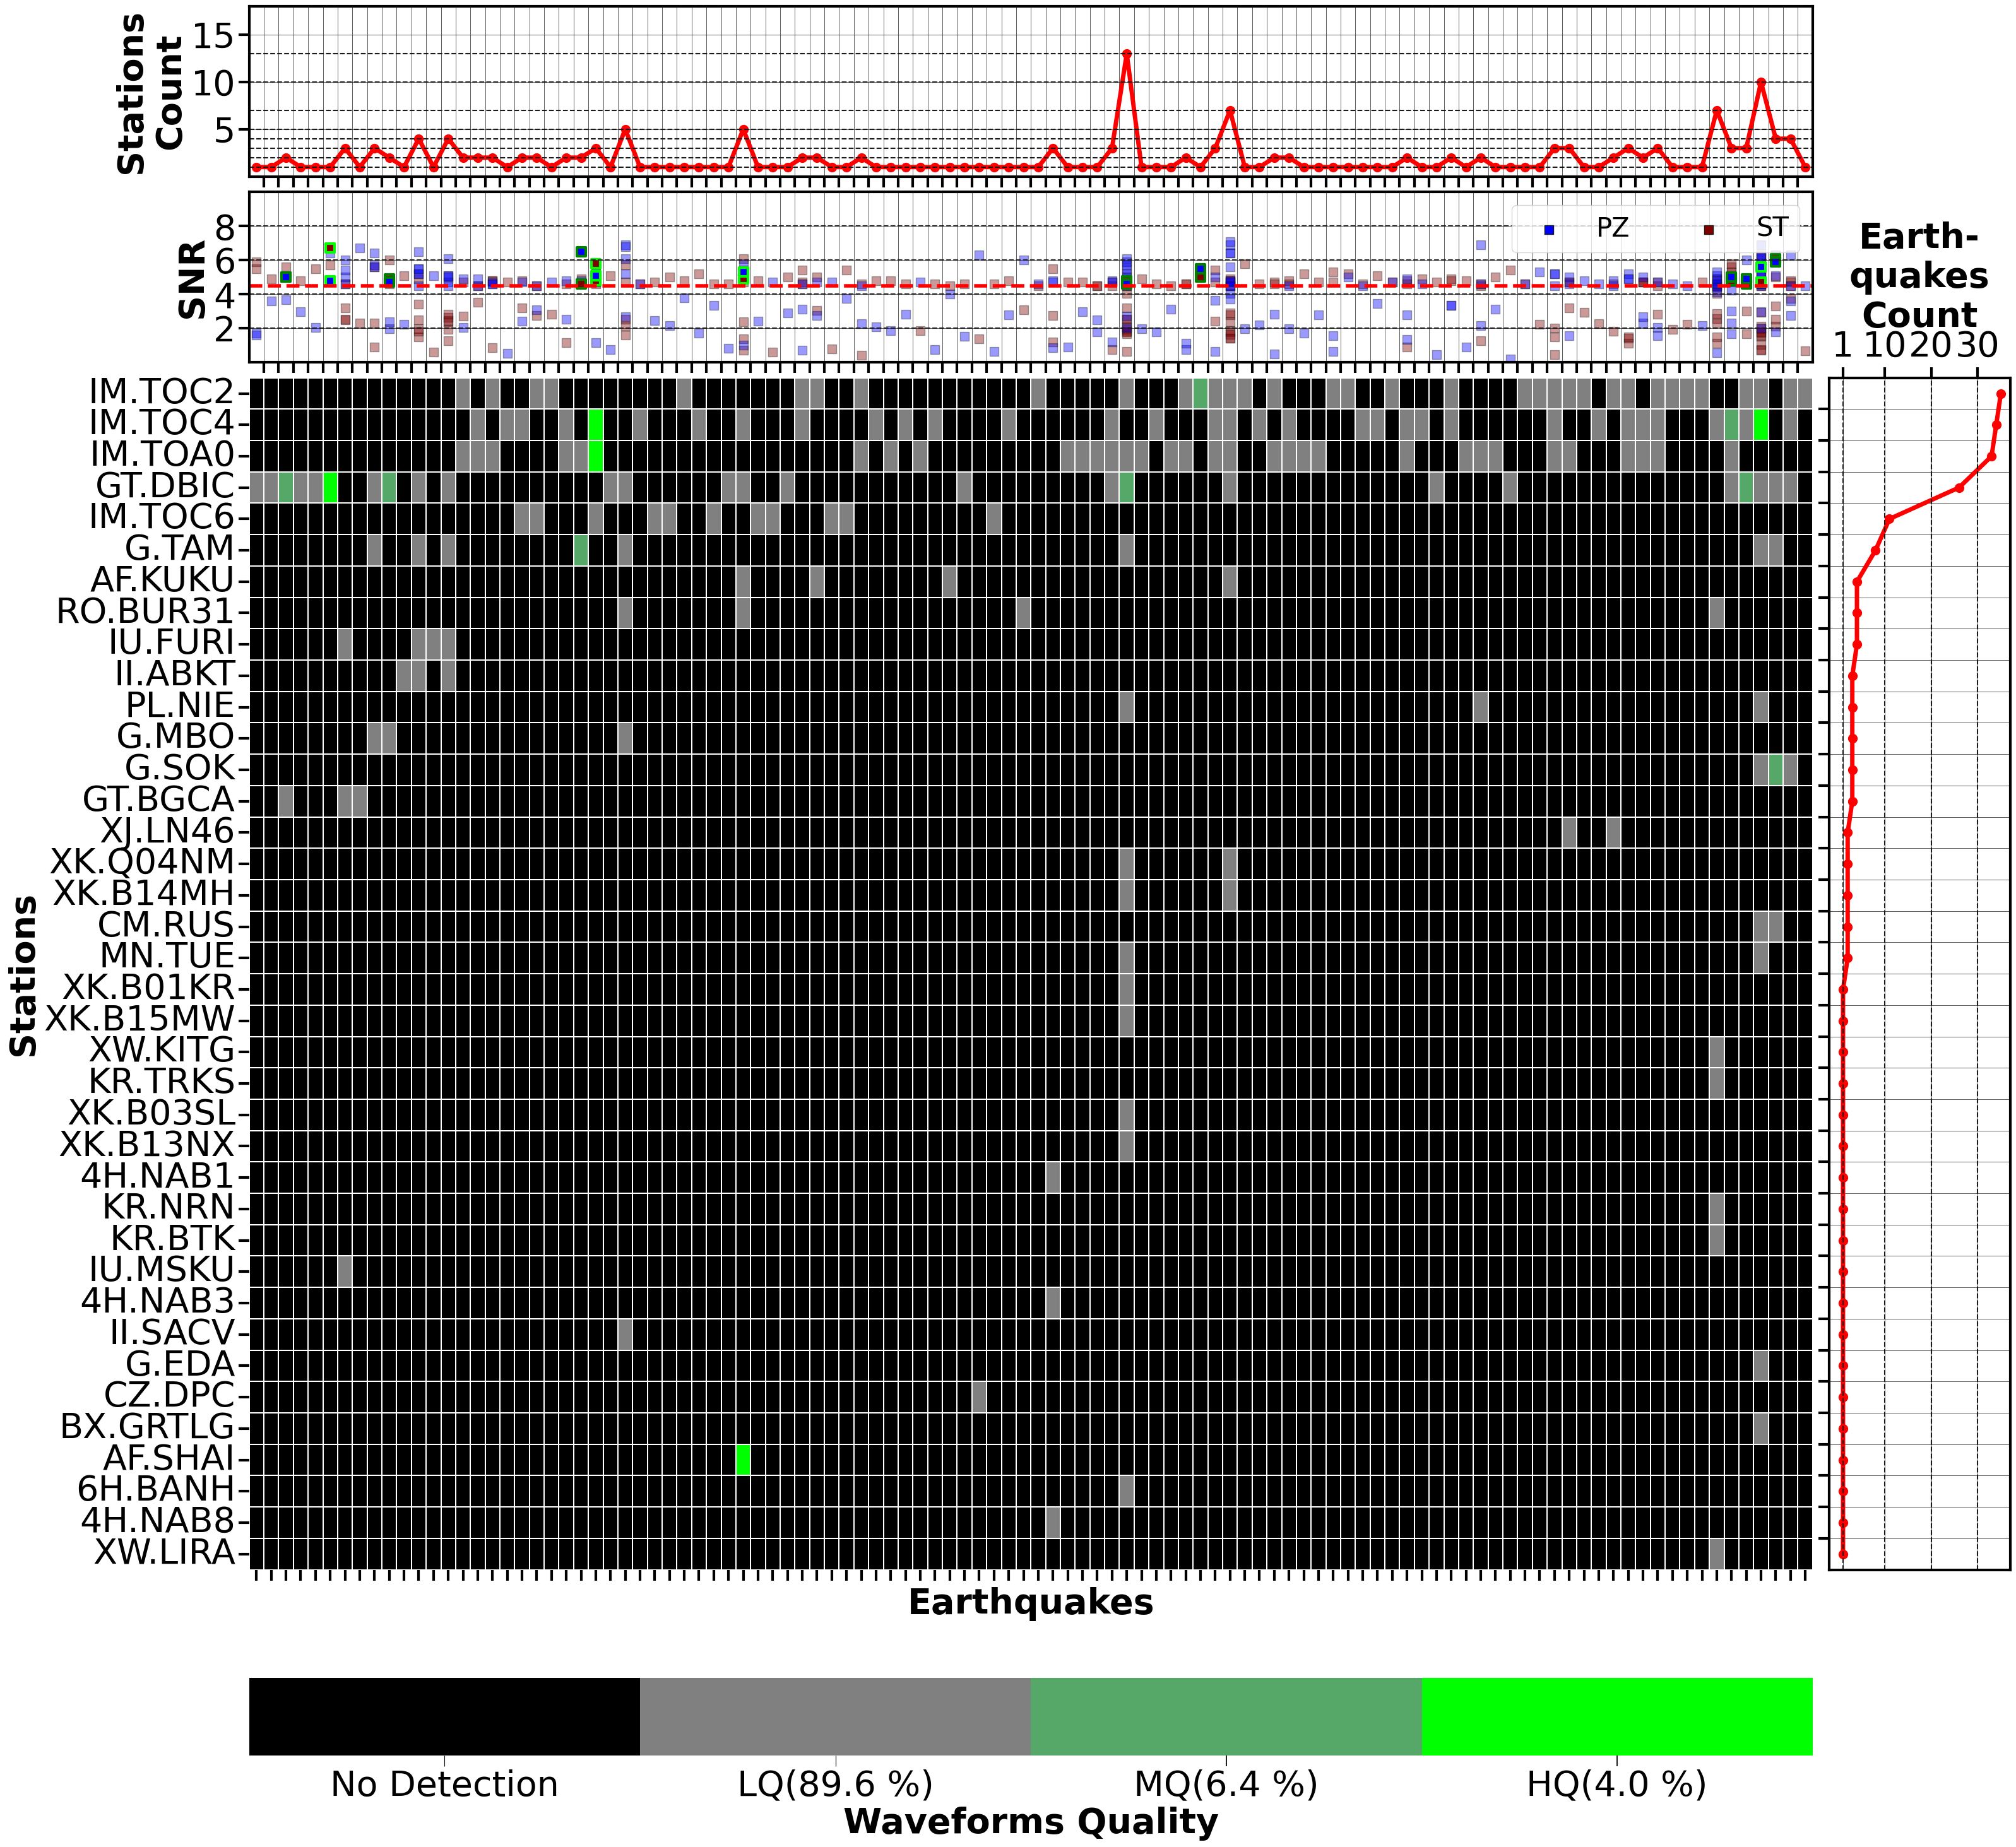

In [42]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (36,36)


#
ax6 = plt.subplot2grid((19, 18),(4, 0), colspan=16,rowspan=13)
cbar_ax = plt.subplot2grid((19, 18),(18, 0), colspan=16,rowspan=1)
sn.set()
# get discrete colormap
cmap = plt.get_cmap('gist_stern',4)
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[1] = "grey"
cmaplist[2] = "g"
cmaplist[3] = "lime"

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# # tell the colorbar to tick at integers
sn.heatmap(data_sorted,linewidths = 0.1, xticklabels = False, 
           cbar_kws={"orientation": "horizontal","shrink" : 2.0},cbar=True,
           cbar_ax=cbar_ax,
           cmap=cmap,
           annot = False,ax=ax6,vmin=-0.5,vmax=3.5)


ax6.set_xticks(np.arange(0.5,106.5))
ax6.set_xlabel("Earthquakes", fontsize = 40,fontweight="bold")
ax6.set_ylabel("Stations",fontsize = 40,fontweight="bold")

ax6.tick_params(axis="both", labelsize=40,direction="out",length=12,width=3)


for axis in ['top','bottom','left','right']:
        ax6.spines[axis].set_linewidth(3)
        
cbar_ax.xaxis.set_ticks([0,1,2,3])
cbar_ax.xaxis.set_ticklabels(["No Detection",f"LQ({Per_LQ} %)",f"MQ({Per_MQ} %)",f"HQ({Per_HQ} %)"])
cbar_ax.set_xlabel("Waveforms Quality",fontsize=40,fontweight="bold")
cbar_ax.tick_params(axis="x", labelsize=40,direction="out",length=12)

plt.style.use('default')
#
ax7 = plt.subplot2grid((19,18),(0, 0), colspan=16,rowspan=2)

ax7.plot(np.arange(0,106,1),y_cstations,color="red",marker='o',markersize=10,linewidth=5)
for i in [1,2,3,4,5,7,10,13]:
    ax7.axhline(i,color="k",linestyle="--")

ax7.set_yticks([5,10,15])
ax7.set_ylim(0,18);
ax7.set_xticks(np.arange(0.5,105,1))
ax7.set_xticklabels([])
ax7.set_xlim(-0.5,105.5)
ax7.grid(color='k', linestyle='-', linewidth=0.5)
ax7.tick_params(axis="both", labelsize=40,direction="out",length=12,width=3)
for axis in ['top','bottom','left','right']:
        ax7.spines[axis].set_linewidth(3)
ax7.set_ylabel("Stations\nCount",fontsize=40,fontweight="bold")

#
origin_LQs = dataAll_LQs['lQindices'].values
#time_origin_Q2= pd.to_datetime(time_origin_Q2)
S_SNR_LQs = dataAll_LQs['S_SNR'].values
P_SNR_LQs = dataAll_LQs['P_SNR'].values

origin_MQ = dataAll_MQ['MQindices'].values
#time_origin_MQ= pd.to_datetime(time_origin_MQ)
S_SNR_MQ = dataAll_MQ['S_SNR'].values
P_SNR_MQ = dataAll_MQ['P_SNR'].values

origin_HQ = dataAll_HQ['HQindices'].values
#time_origin_HQ= pd.to_datetime(time_origin_HQ)
S_SNR_HQ = dataAll_HQ['S_SNR'].values
P_SNR_HQ = dataAll_HQ['P_SNR'].values


ax8 = plt.subplot2grid((19,18),(2, 0), colspan=16,rowspan=2)

ax8.scatter(origin_LQs,S_SNR_LQs,marker="s",s=100,c="maroon",edgecolors="k",alpha=0.4)
ax8.scatter(origin_LQs,P_SNR_LQs,marker="s",s=100,c="blue",edgecolors="k",alpha=0.4)

ax8.scatter(origin_MQ,S_SNR_MQ,marker="s",s=100,c="maroon",edgecolors="green",linewidths=3)
ax8.scatter(origin_MQ,P_SNR_MQ,marker="s",s=100,c="blue",edgecolors="green",linewidths=3)

ax8.scatter(origin_HQ[0],P_SNR_HQ[0],marker="s",s=100,c="blue",edgecolors="k",label= "PZ")
ax8.scatter(origin_HQ[0],S_SNR_HQ[0],marker="s",s=100,c="maroon",edgecolors="k",label= "ST")
ax8.scatter(origin_HQ,S_SNR_HQ,marker="s",s=100,c="maroon",edgecolors="lime",linewidths=3)
ax8.scatter(origin_HQ,P_SNR_HQ,marker="s",s=100,c="blue",edgecolors="lime",linewidths=3)
for i in [2,4,6,8]:
    ax8.axhline(i,color="k",linestyle="--")

ax8.axhline(4.5,color="red",linestyle="--",linewidth=4)
ax8.set_yticks(np.arange(2,9,2))
ax8.set_ylim(0,10);
ax8.set_xlim(-0.5,105.5);
ax8.set_xticks(np.arange(0.5,105.5,1))
ax8.set_xticklabels([])
ax8.grid(color='k', linestyle='-', linewidth=0.5)
ax8.tick_params(axis="both", labelsize=40,direction="out",length=12,width=3)
ax8.legend(ncol =2 , loc="upper right",prop={"size": 30},fontsize=40)
for axis in ['top','bottom','left','right']:
        ax8.spines[axis].set_linewidth(3)
ax8.set_ylabel("SNR",fontsize=40,fontweight="bold")       

#
x_cearthquakes_ =np.flip(x_cearthquakes)
ax9 = plt.subplot2grid((19,18), (4, 16), colspan=2,rowspan=13)
ax9.plot(x_cearthquakes_,np.arange(0.5,38,1),color="red",marker='o',markersize=10,linewidth=5)
for i in [1,10,20,30]:
    ax9.axvline(i,color="k",linestyle="--")
ax9.grid(color='k', linestyle='-', linewidth=0.5)
ax9.set_yticks(np.arange(1,38,1))
ax9.set_yticklabels([])
#ax9.set_yticks(np.arange(0.5,38,1), minor=True)
#ax9.set_yticklabels(uStations_sorted,minor=True)
ax9.xaxis.tick_top()        
ax9.set_xlim(-2,37)
ax9.set_xticks([1,10,20,30])
ax9.set_ylim(0,38);
ax9.tick_params(axis="both",labelsize=40,direction="out",length=12,width=3)      
for axis in ['top','bottom','left','right']:
        ax9.spines[axis].set_linewidth(3) 
ax9.set_xlabel("Earth-\nquakes\nCount",fontsize=40,fontweight="bold")
ax9.xaxis.set_label_position('top')

output ="Output/Figures/"
plt.savefig(pjoin(output,"Figure_S6.pdf"),dpi=600,)


plt.show()

In [ ]:
Time = dataAll_Q['origin'].values
Stations = dataAll_Q['station'].values

In [ ]:
HQStations = dataAll_HQ['station'].unique()
MQStations = dataAll_MQ['station'].unique()
HQ_MQStations = np.concatenate((HQStations,MQStations),axis=0)
HQ_MQStations = np.sort(HQ_MQStations)
HQ_MQStations = pd.Series(HQ_MQStations)
HQ_MQStations = HQ_MQStations.unique()
print(HQ_MQStations)

In [ ]:
# Fill matrice with 1 for each earthquake-station match
HQ_MQTime = dataAll_Q['origin'].unique()


print(f"Count unique stations: {len(HQ_MQStations)}")
print(f"Count unique earthquakes:{len(HQ_MQTime)}")

HQ_MQdata = pd.DataFrame(columns = HQ_MQTime ,
        index = HQ_MQStations)


for HMdate, HMstation in zip(Time,Stations):
    HQ_MQdata[HMdate][HMstation] = 1

for idat in HQ_MQTime:
    HQ_MQdata[idat]=HQ_MQdata[idat].fillna(0)

Time2= []
for i in HQ_MQTime:
    Time2.append(i[0:])
       
HQ_MQdata.columns = Time2

HQ_MQdata

In [ ]:
#Total Record per Stations
HQ_MQRecord_count= HQ_MQdata.sum(axis=1)

HQ_MQRecord_count=HQ_MQRecord_count.sort_values(ascending = False)
HQ_MQrsum = HQ_MQRecord_count.sum()
print(HQ_MQrsum)

HQ_MQRecord_count = HQ_MQRecord_count.to_frame().reset_index()
HQ_MQRecord_count.rename(columns = {'index':'Stations', 0:'Earthquake_counts'}, inplace = True)

y_HQ_MQstations = HQ_MQRecord_count['Stations'].values
x_HQ_MQcearthquakes = HQ_MQRecord_count['Earthquake_counts'].values


print(y_HQ_MQstations)
print(HQ_MQRecord_count)

In [ ]:
#uTime = dataAll_Q['origin'].unique()
#uStations = dataAll_Q['station'].unique()
#uStations = np.sort(uStations)

HQ_MQStations_sorted=y_HQ_MQstations
HQ_MQdata_sorted = pd.DataFrame(columns = HQ_MQTime ,
        index = HQ_MQStations_sorted)

Time_HQ = dataAll_HQ['origin'].values
Stations_HQ = dataAll_HQ['station'].values

Time_MQ = dataAll_MQ['origin'].values
Stations_MQ = dataAll_MQ['station'].values

Time_LQ = dataAll_LQ['origin'].values
Stations_LQ = dataAll_LQ['station'].values

Time_LQ_High = dataAll_LQ_High['origin'].values
Stations_LQ_High = dataAll_LQ_High['station'].values

Time_LQ_Low = dataAll_LQ_Low['origin'].values
Stations_LQ_Low = dataAll_LQ_Low['station'].values

for date, station in zip(Time_LQ_Low,Stations_LQ_Low):
    HQ_MQdata_sorted[date][station] = 1
    
for date, station in zip(Time_LQ_High,Stations_LQ_High):
    HQ_MQdata_sorted[date][station] = 1

for date, station in zip(Time_LQ,Stations_LQ):
    HQ_MQdata_sorted[date][station] = 1
    
for date, station in zip(Time_MQ,Stations_MQ):
    HQ_MQdata_sorted[date][station] = 2

for date, station in zip(Time_HQ,Stations_HQ):
    HQ_MQdata_sorted[date][station] = 3   
    
for idat in HQ_MQTime:
    HQ_MQdata_sorted[idat]=HQ_MQdata_sorted[idat].fillna(0)

Time2_= []
for i in HQ_MQTime:
    Time2_.append(i[0:10])
    
#Time = pd.to_datetime(Time)    
HQ_MQdata_sorted.columns = Time2_

HQ_MQdata_sorted

In [ ]:
#Total Record per Earthquake
HQ_MQRecord_count_E= HQ_MQdata.sum(axis=0)
HQ_MQRecord_count_E=HQ_MQRecord_count_E.sort_values(ascending = False)
HQ_MQrsum_E = HQ_MQRecord_count_E.sum()
print(HQ_MQrsum_E)

HQ_MQRecord_count_E = HQ_MQRecord_count_E.to_frame().reset_index()

HQ_MQRecord_count_E.rename(columns = {'index':'Earthquakes', 0:'Station_counts'}, inplace = True)

HQ_MQRecord_count_E.sort_values(by=['Earthquakes'],ascending = True,inplace = True)

print(HQ_MQRecord_count_E)

x_HQ_MQearthquakes = HQ_MQRecord_count_E['Earthquakes'].values

y_HQ_MQcstations = HQ_MQRecord_count_E['Station_counts'].values

In [ ]:
#SNR for HQ_MQ Stations
print(y_HQ_MQstations)
datasta_frameLQs = pd.DataFrame(columns=list(dataAll_LQs.columns))
datasta_frameMQ = pd.DataFrame(columns=list(dataAll_MQ.columns))
datasta_frameHQ = pd.DataFrame(columns=list(dataAll_HQ.columns))
#Data frame
for sta in y_HQ_MQstations:
    data4staLQs = dataAll_LQs[dataAll_LQs["station"]==sta]
    datasta_frameLQs = datasta_frameLQs.append(data4staLQs)
    

Sta_S_SNRsLQs = datasta_frameLQs['S_SNR'].values
Sta_P_SNRsLQs = datasta_frameLQs['P_SNR'].values

#Data frame
for sta in y_HQ_MQstations:
    data4staMQ = dataAll_MQ[dataAll_MQ["station"]==sta]
    datasta_frameMQ = datasta_frameMQ.append(data4staMQ)
    

Sta_S_SNRsMQ = datasta_frameMQ['S_SNR'].values
Sta_P_SNRsMQ = datasta_frameMQ['P_SNR'].values

#Data frame
for sta in y_HQ_MQstations:
    data4staHQ = dataAll_HQ[dataAll_HQ["station"]==sta]
    datasta_frameHQ = datasta_frameHQ.append(data4staHQ)
    

Sta_S_SNRsHQ = datasta_frameHQ['S_SNR'].values
Sta_P_SNRsHQ = datasta_frameHQ['P_SNR'].values



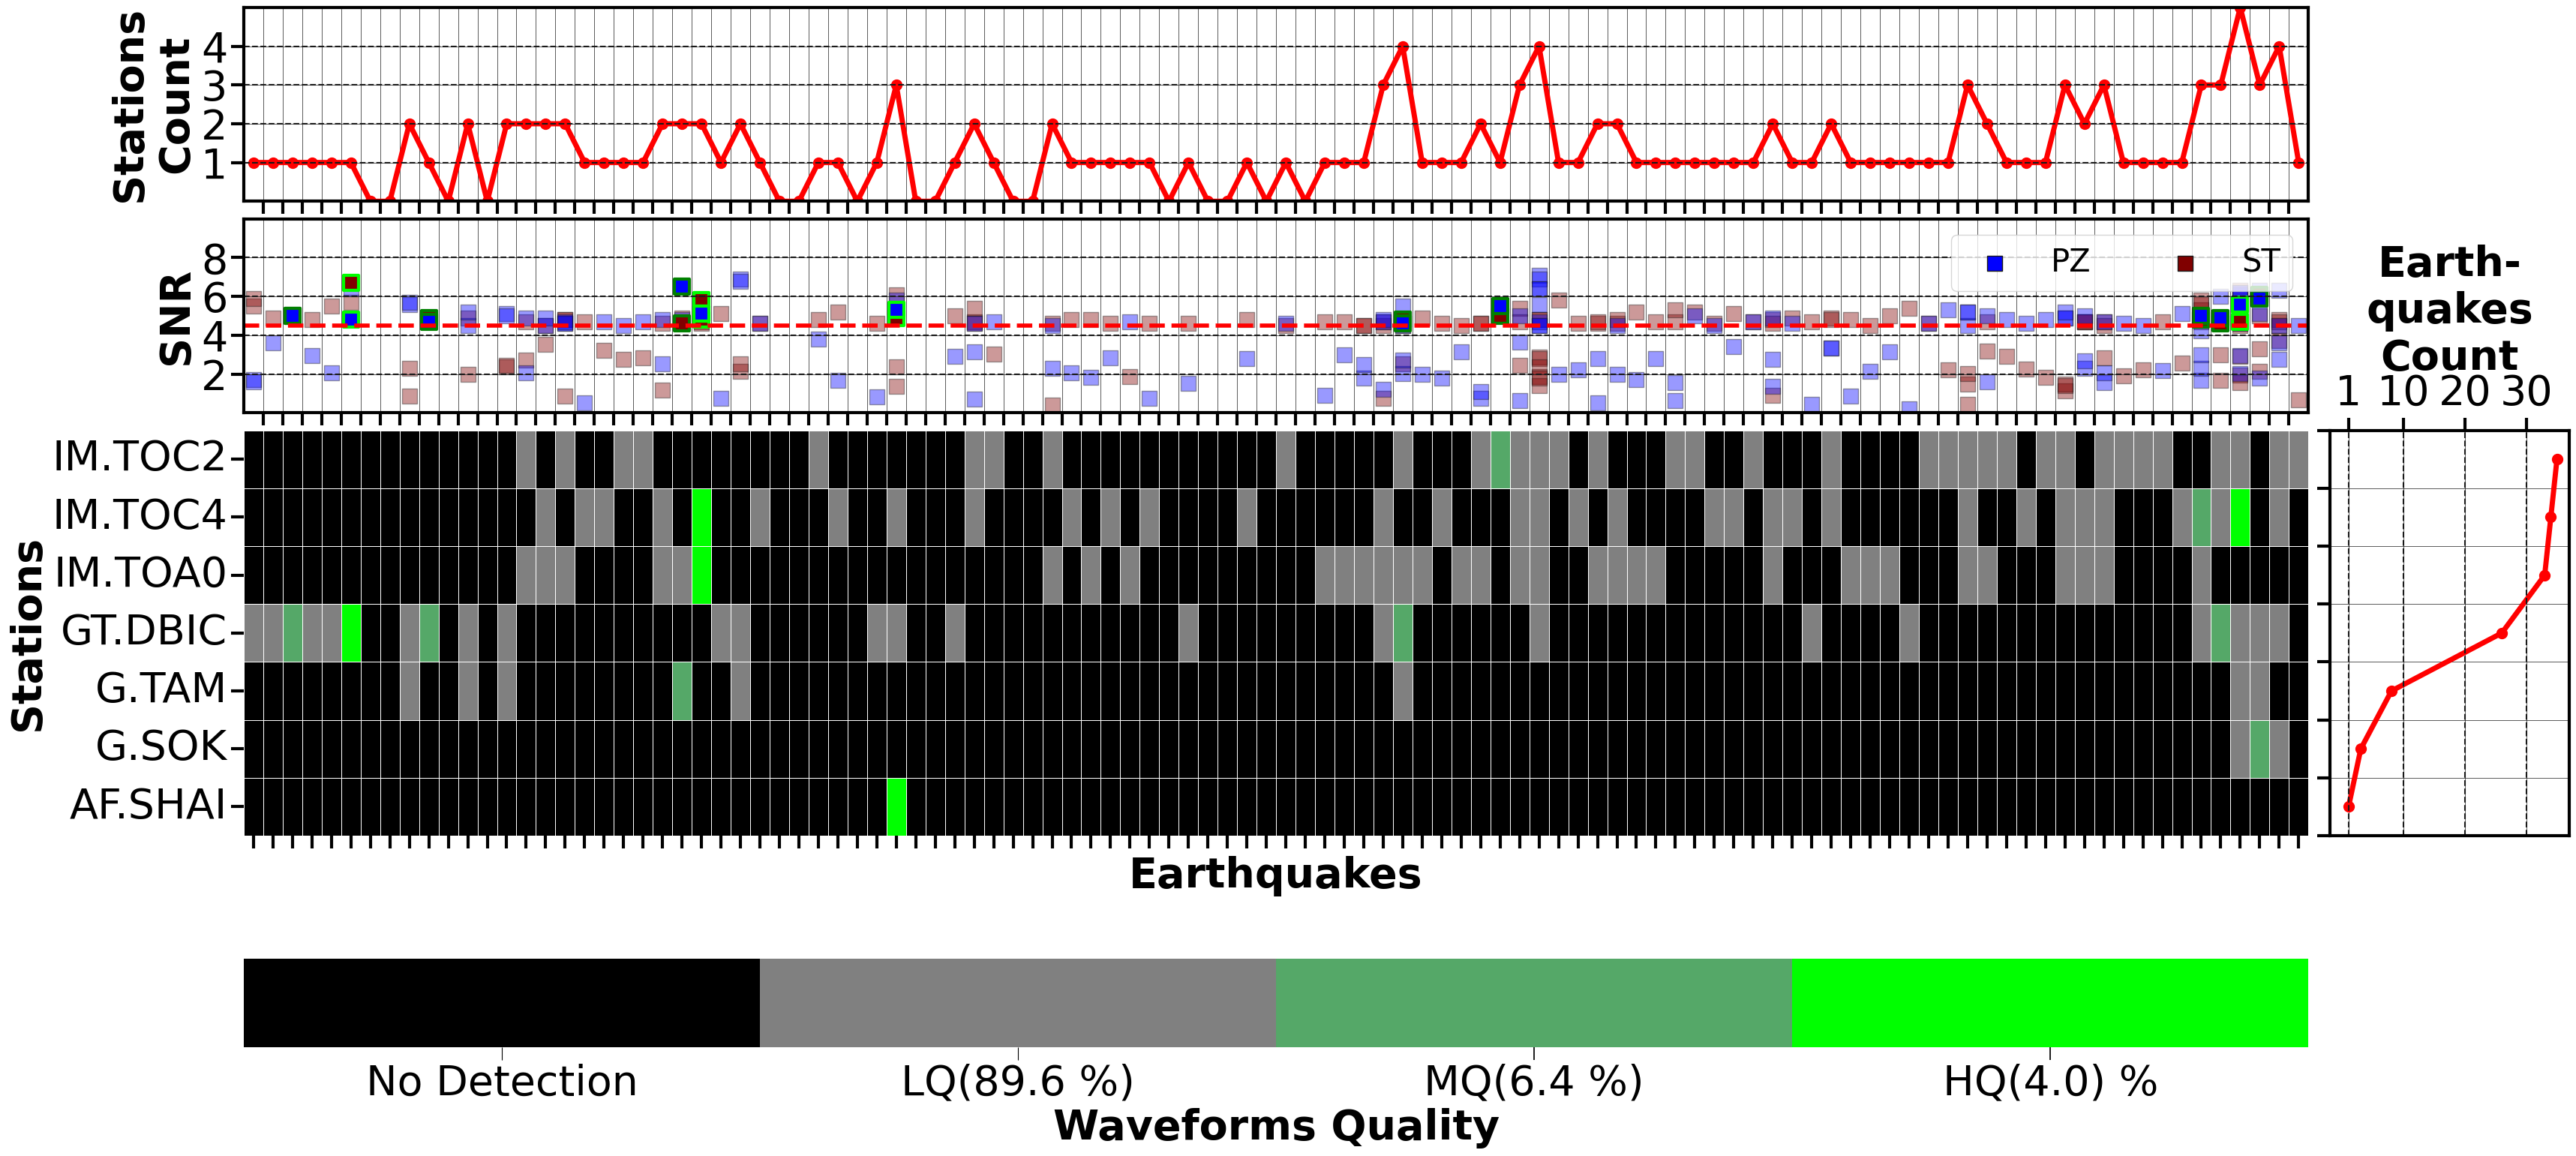

In [43]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (40,18)


#
ax6 = plt.subplot2grid((10, 18),(4, 0), colspan=16,rowspan=4)
cbar_ax = plt.subplot2grid((10, 18),(9, 0), colspan=16,rowspan=1)
sn.set()
# get discrete colormap
cmap = plt.get_cmap('gist_stern',4)
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[1] = "grey"
cmaplist[2] = "g"
cmaplist[3] = "lime"

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# # tell the colorbar to tick at integers
sn.heatmap(HQ_MQdata_sorted,linewidths = 0.5, xticklabels = False, 
           cbar_kws={"orientation": "horizontal","shrink" : 2.0},cbar=True,
           cbar_ax=cbar_ax,
           cmap=cmap,
           annot = False,ax=ax6,vmin=-0.5,vmax=3.5)

ax6.set_xticks(np.arange(0.5,106.5,1))
ax6.set_xlabel("Earthquakes", fontsize = 40,fontweight="bold")
ax6.set_ylabel("Stations",fontsize = 40,fontweight="bold")

ax6.tick_params(axis="x", labelsize=40,direction="out",length=12,width=3)
ax6.tick_params(axis="y", labelsize=40,direction="out",length=12,width=3,labelrotation=0)

for axis in ['top','bottom','left','right']:
        ax6.spines[axis].set_linewidth(3)
        
cbar_ax.xaxis.set_ticks([0,1,2,3])
cbar_ax.xaxis.set_ticklabels(["No Detection",f"LQ({Per_LQ} %)",f"MQ({Per_MQ} %)",f"HQ({Per_HQ}) %"])
cbar_ax.set_xlabel("Waveforms Quality",fontsize=40,fontweight="bold")
cbar_ax.tick_params(axis="x", labelsize=40,direction="out",length=12)

plt.style.use('default')
#
ax7 = plt.subplot2grid((10,18),(0, 0), colspan=16,rowspan=2)

ax7.plot(np.arange(0,106,1),y_HQ_MQcstations,color="red",marker='o',markersize=10,linewidth=5)
for i in [1,2,3,4]:
    ax7.axhline(i,color="k",linestyle="--")

ax7.set_yticks([1,2,3,4])
ax7.set_ylim(0,5);
ax7.set_xticks(np.arange(0.5,105,1))
ax7.set_xticklabels([])
ax7.set_xlim(-0.5,105.5)
ax7.grid(color='k', linestyle='-', linewidth=0.5)
ax7.tick_params(axis="both", labelsize=40,direction="out",length=12,width=3)
for axis in ['top','bottom','left','right']:
        ax7.spines[axis].set_linewidth(3)
ax7.set_ylabel("Stations\nCount",fontsize=40,fontweight="bold")

#
origin_LQs = datasta_frameLQs['lQindices'].values
origin_MQ = datasta_frameMQ['MQindices'].values
origin_HQ = datasta_frameHQ['HQindices'].values


Sta_S_SNRsLQs
Sta_P_SNRsLQs
Sta_S_SNRsMQ
Sta_P_SNRsMQ
Sta_S_SNRsHQ
Sta_P_SNRsHQ

ax8 = plt.subplot2grid((10,18),(2, 0), colspan=16,rowspan=2)

ax8.scatter(origin_LQs,Sta_S_SNRsLQs,marker="s",s=200,c="maroon",edgecolors="k",alpha=0.4)
ax8.scatter(origin_LQs,Sta_P_SNRsLQs,marker="s",s=200,c="blue",edgecolors="k",alpha=0.4)

ax8.scatter(origin_MQ,Sta_S_SNRsMQ,marker="s",s=200,c="maroon",edgecolors="green",linewidths=3)
ax8.scatter(origin_MQ,Sta_P_SNRsMQ,marker="s",s=200,c="blue",edgecolors="green",linewidths=3)

ax8.scatter(origin_HQ[0],Sta_P_SNRsHQ[0],marker="s",s=200,c="blue",edgecolors="k",label= "PZ")
ax8.scatter(origin_HQ[0],Sta_P_SNRsHQ[0],marker="s",s=200,c="maroon",edgecolors="k",label= "ST")
ax8.scatter(origin_HQ,Sta_S_SNRsHQ,marker="s",s=200,c="maroon",edgecolors="lime",linewidths=3)
ax8.scatter(origin_HQ,Sta_P_SNRsHQ,marker="s",s=200,c="blue",edgecolors="lime",linewidths=3)
for i in [2,4,6,8]:
    ax8.axhline(i,color="k",linestyle="--")

ax8.axhline(4.5,color="red",linestyle="--",linewidth=4)
ax8.set_yticks(np.arange(2,9,2))
ax8.set_ylim(0,10);
ax8.set_xlim(-0.5,105.5);
ax8.set_xticks(np.arange(0.5,105.5,1))
ax8.set_xticklabels([])
ax8.grid(color='k', linestyle='-', linewidth=0.5)
ax8.tick_params(axis="both", labelsize=40,direction="out",length=12,width=3)
ax8.legend(ncol =2 , loc="upper right",prop={"size": 30},fontsize=40)
for axis in ['top','bottom','left','right']:
        ax8.spines[axis].set_linewidth(3)
ax8.set_ylabel("SNR",fontsize=40,fontweight="bold")       

#
x_HQ_MQcearthquakes_ =np.flip(x_HQ_MQcearthquakes)
ax9 = plt.subplot2grid((10,18), (4, 16), colspan=2,rowspan=4)
ax9.plot(x_HQ_MQcearthquakes_,np.arange(0.5,7,1),color="red",marker='o',markersize=10,linewidth=5)
for i in [1,10,20,30]:
    ax9.axvline(i,color="k",linestyle="--")
ax9.grid(color='k', linestyle='-', linewidth=0.5)
ax9.set_yticks(np.arange(-1,8,1))
ax9.set_yticklabels([])
#ax9.set_yticks(np.arange(0.5,38,1), minor=True)
#ax9.set_yticklabels(uStations_sorted,minor=True)
ax9.xaxis.tick_top()        
ax9.set_xlim(-2,37)
ax9.set_xticks([1,10,20,30])
ax9.set_ylim(0,7);
ax9.tick_params(axis="both",labelsize=40,direction="out",length=12,width=3)      
for axis in ['top','bottom','left','right']:
        ax9.spines[axis].set_linewidth(3) 
ax9.set_xlabel("Earth-\nquakes\nCount",fontsize=40,fontweight="bold")
ax9.xaxis.set_label_position('top')

output ="Output/Figures/"
plt.savefig(pjoin(output,"Figure_2a.pdf"),dpi=600,)

plt.show()